TITLE: Types of MineCraft Players that should be Recruited to Maximize Data for Research

INTRODUCTION:
A research group led by Frank Wood in Computer Science at UBC is collecting data about how people play video games. To conduct this study, they set up a MineCraft server and recorded how players played the game. They collected basic information about the player like their name, age, and gender, as well as data about their experience level with the game, subscription status to a game-related newsletter, and their total hours played.

This report aims to answer the following question: "Can a player's age predict the hours they spend playing MineCraft in players.csv?"

The dataset used to answer this question is contained within the file "players.csv". This dataset contains 196 rows of observations and 7 variables:
- experience: a character data type that describes the level of expertise of the player with the MineCraft game. There are 5 possible observations: "amateur", "beginner", "regular", "pro", and "veteran".
- subscribe: a logical data type that shares whether the player has subscribed to a game-related newsletter or not. Possible observations are "TRUE", for having subscribed, or "FALSE", for not having a subscription.
- hashedEmail: a character data type where the observation is the email address of the player that had a hashing algorithm applied to protect the user's privacy.
- played_hours: a double data type where the observations are numerical values that represent the number of hours the player has spent playing the game. Values seen are within the range of 0-223.1.
- name: a character data type representing the first names of the players studied.
- gender: a character data type where the possible inputs are "Male", "Female", "Non-binary", "Two-Spirited", "Agender", "Prefer not to say", and "Other".
- Age: a double data type where the values represent the age of the players, with one cell containing "NA".

An issue that I notice right away in the data is that the column names are not as clean as they could be, with some names containing a _ with others having two words written as one, or some with an uppercase letter. Additionally, because the question requires creating a regression model, I would need to alter the experience variable so that it can be represented on a numerical scale.

METHODS & RESULTS: 

In [48]:
#loading the tidyverse package
library(tidyverse)

In [32]:
#loading the data
players_data <- read_csv("data/players.csv")
head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [82]:
#first select columns of interest
players_data <- select(players_data, Age, played_hours)
head(players_data)

Age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
17,0.0
21,0.7
21,0.1
17,0.0


In [85]:
#rename column to be all lowercase
players <- players_data |> mutate(age = Age) |>
    select(age, played_hours) |>
    filter(age != "NA")
players

age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
17,0.0
21,0.7
21,0.1
17,0.0
19,0.0
21,0.0
17,0.1


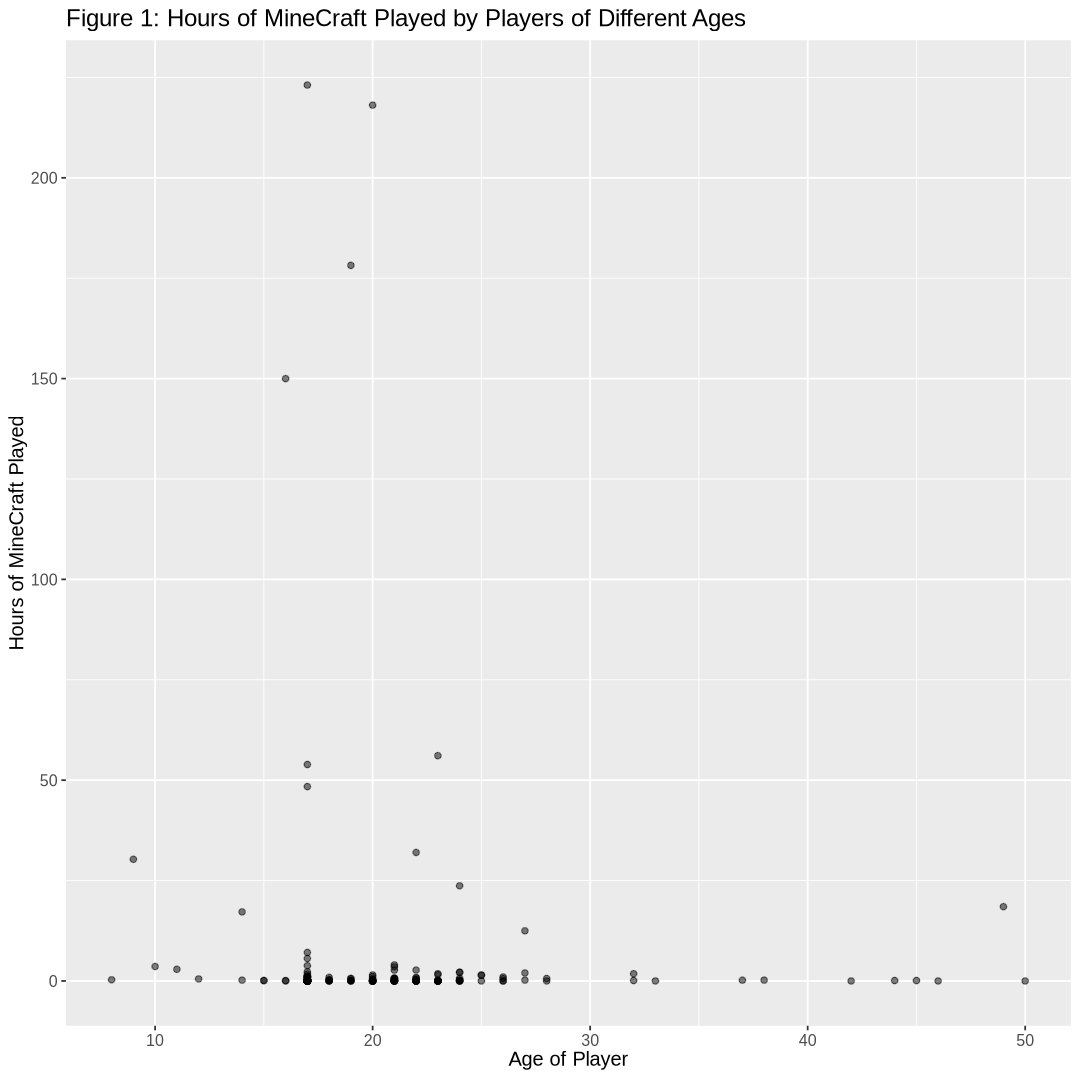

In [87]:
#create visualization of dataset for exploratory data analysis
options(repr.plot.width = 9, repr.plot.height = 9)

players_graph <- players |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.5) +
    ggtitle("Figure 1: Hours of MineCraft Played by Players of Different Ages") +
    labs(x = "Age of Player", y = "Hours of MineCraft Played") +
    theme(text = element_text(size = 12))
players_graph

We can see that in Figure 1 it is quite difficult to clearly visualize a trend because of how many players played no hours. Thankfully, due to the lowered opacity of the data points, we can also see that most of the students studied were around the ages 15-30, many of whom played no hours or very minimal hours of MineCraft. Furthermore, the highest times played are by players within an age range of around 15-25. In order to predict the hours played by players of different ages to figure out who to focus recruiting efforts to, it would be better to eliminate the data points from players who played 0 hours to see who played a lot or very little rather than having the model focus on players who did not play at all. 

age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
21,0.7
21,0.1
17,0.1
23,1.6


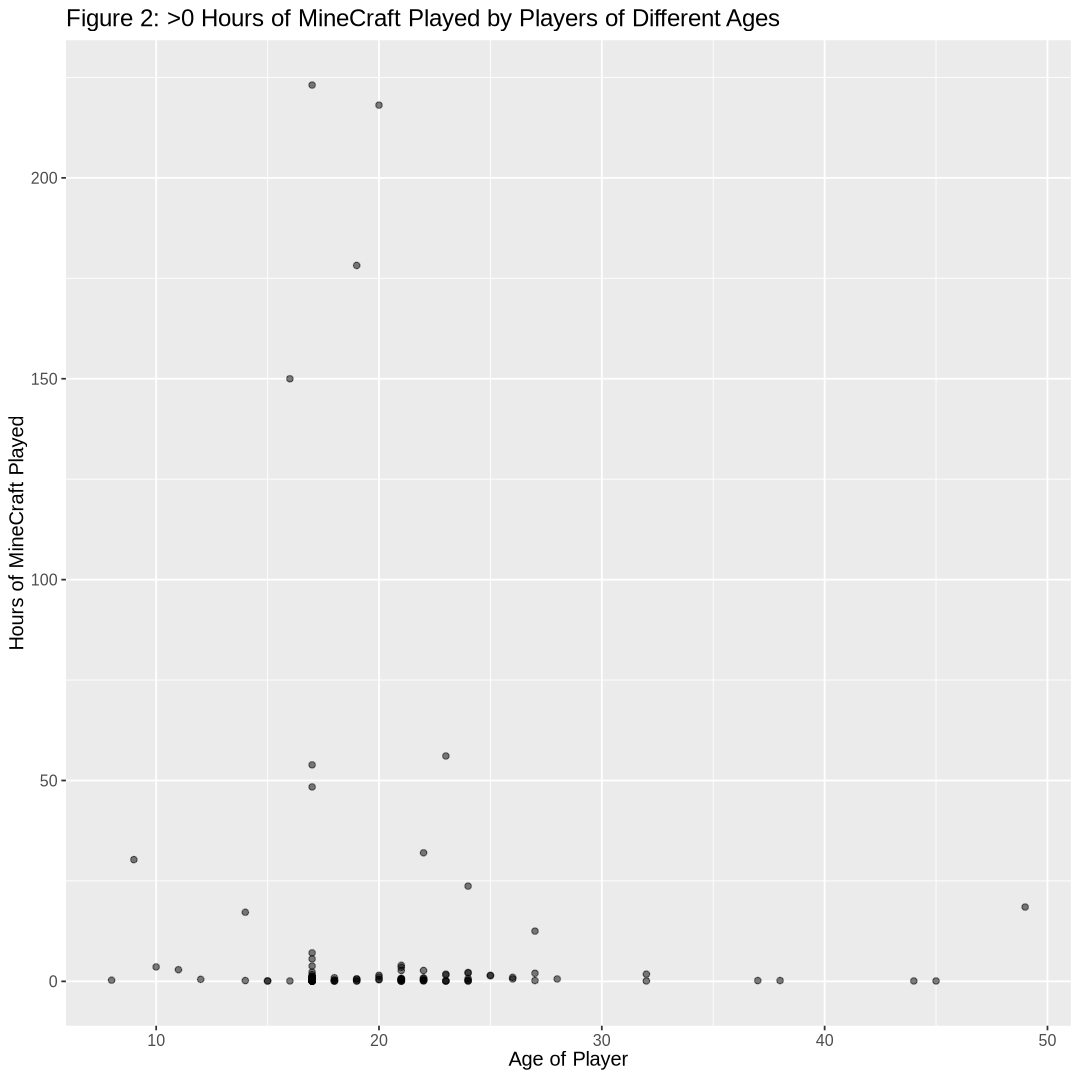

In [91]:
players_0 <- players |>
    filter(played_hours > 0)
head(players_0)

players_graph_0 <- players_0 |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.5) +
    ggtitle("Figure 2: >0 Hours of MineCraft Played by Players of Different Ages") +
    labs(x = "Age of Player", y = "Hours of MineCraft Played") +
    theme(text = element_text(size = 12))
players_graph_0